# Phishing and Spam Detection Using Various Machine Learning Algorithms

# 1 Introduction

Authors: Anisaftab Saiyed, Terrence Manly-Elliott, Noah Ndahirwa
Supervisor: Mohamad Hoda

In this research project, our objective is to develop machine learning models that can effectively detect spam and phishing emails. Spam and phishing emails pose significant threats to individuals and organizations, as they aim to deceive recipients and extract sensitive information or engage in malicious activities.

The detection of spam and phishing emails is a challenging task due to the constantly evolving techniques used by attackers. Machine learning algorithms provide a promising approach to tackle this problem by leveraging patterns and features within email content, headers, and metadata.

By training machine learning models on a diverse dataset of labeled emails, we aim to build robust classifiers that can accurately identify and classify spam and phishing emails. These models will be capable of distinguishing between legitimate emails and malicious ones, enabling users to take appropriate actions to protect themselves and their organizations.

Throughout this research project, we will explore various machine learning algorithms, including logistic regression, support vector machines, random forests, and neural networks. We will evaluate the performance of these models using metrics such as accuracy, precision, recall, and F1-score.

The outcomes of this research project have the potential to contribute to the development of effective email filtering systems and enhance email security for individuals and organizations. By improving the detection of spam and phishing emails, we can mitigate the risks associated with cyber threats and safeguard sensitive information.

# 2 Imports

In [228]:
import pandas as pd
import numpy as np
import re
import quopri
import spacy
import gc
import os
import warnings
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
import prettytable as pt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from bs4 import BeautifulSoup
from email import message_from_string
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import joblib 

In [229]:
warnings.filterwarnings('ignore')

# 3 Data Preparation

Useful Functions

In [230]:
#Function to convert MIME to plain text
def mime_to_text(mime_text):
  #Parse the MIME content
  email_message = message_from_string(mime_text)
  text_content = ""

  #Check if the email is multipart
  if email_message.is_multipart():
      for part in email_message.walk():
          content_type = part.get_content_type()
          content_disposition = str(part.get("Content-Disposition"))

          #Extract plain text
          if content_type == "text/plain" and "attachment" not in content_disposition:
              text = part.get_payload(decode=True)
              try:
                  text_content += text.decode('utf-8')
              except UnicodeDecodeError:
                  text_content += text.decode('utf-8', errors='replace')
          #Convert HTML parts to text
          elif content_type == "text/html" and "attachment" not in content_disposition:
              html = part.get_payload(decode=True)
              try:
                  soup = BeautifulSoup(html.decode('utf-8'), "html.parser")
                  text_content += soup.get_text()
              except UnicodeDecodeError:
                  soup = BeautifulSoup(html.decode('utf-8', errors='replace'), "html.parser")
                  text_content += soup.get_text()
  else:
      #Return text if not multipart
      try:
          text_content = email_message.get_payload(decode=True).decode('utf-8')
      except UnicodeDecodeError:
          text_content = email_message.get_payload(decode=True).decode('utf-8', errors='replace')
  return text_content

#function to convert html to plain text
def html_to_text(text):
  soup = BeautifulSoup(text, 'lxml')
  return soup.get_text()

## 3.1 Spam Dataset

### 3.1.1 Data Extraction

In [231]:
spam_df = pd.read_csv("https://raw.githubusercontent.com/terrenceme/Honours_Project/main/Spam%20Email%20raw%20text%20for%20NLP.csv")
spam_df.rename(columns={'CATEGORY': 'SPAM_CATEGORY'}, inplace=True)

In [232]:
# Display the entire content of MESSAGE column
pd.set_option('display.max_colwidth', 1000)
#Removing unrequired column
spam_df.drop(columns=['FILE_NAME'], inplace=True)
spam_df.head()

,SPAM_CATEGORY,MESSAGE
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\nperfect credit!\n\n\n\nThis service is 100% FREE to home owners and new\n\nhome buyers without any obligation. \n\n\n\nJust fill out a quick, simple form and jump-start\n\nyour future plans today!\n\n\n\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\n\n\nhttp://61.145.116.186/light/watch.asp\n\n\n\n\n"
1,1,ATTENTION: This is a MUST for ALL Computer Users!!!\n\n\n\n*NEW-Special Package Deal!*\n\n\n\nNorton SystemWorks 2002 Software Suite -Professional Edition-\n\n\n\nIncludes Six - Yes 6! - Feature-Packed Utilities\n\nALL For 1 Special LOW Price!\n\n\n\nThis Software Will:\n\n- Protect your computer from unwanted and hazardous viruses\n\n- Help secure your private & valuable information\n\n- Allow you to transfer files and send e-mails safely\n\n- Backup your ALL your data quick and easily\n\n- Improve your PC's performance w/superior integral diagnostics!\n\n\n\n6 Feature-Packed Utilities...1 Great Price!\n\nA $300+ Combined Retail Value!\n\n\n\nYOURS for Only $29.99! <Includes FREE Shipping!>\n\n\n\nDon't fall prey to destructive viruses or hackers!\n\nProtect your computer and your valuable information!\n\n\n\n\n\nSo don't delay...get your copy TODAY!\n\n\n\n\n\nhttp://euro.specialdiscounts4u.com/\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n...
2,1,"This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset=""Windows-1252""\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don't want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead,..."
3,1,"IMPORTANT INFORMATION:\n\n\n\nThe new domain names are finally available to the general public at discount prices. Now you can register one of the exciting new .BIZ or .INFO domain names, as well as the original .COM and .NET names for just $14.95. These brand new domain extensions were recently approved by ICANN and have the same rights as the original .COM and .NET domain names. The biggest benefit is of-course that the .BIZ and .INFO domain names are currently more available. i.e. it will be much easier to register an attractive and easy-to-remember domain name for the same price. Visit: http://www.affordable-domains.com today for more info.\n\n \n\nRegister your domain name today for just $14.95 at: http://www.affordable-domains.com/ Registration fees include full access to an easy-to-use control panel to manage your domain name in the future.\n\n \n\nSincerely,\n\n \n\nDomain Administrator\n\nAffordable Domains\n\n\n\n\n\nTo remove your email address from further promotional..."
4,1,"This is the bottom line. If you can GIVE AWAY CD's for FREE to people (like 80-100 in one month) and then let ME talk to them FOR you - if you can GIVE AWAY free product samples - then YOU can earn $5,000 in the next 30 - 45 days.\n\n\n\nThink I'm kidding? We earned PRECISELY $26,087.

### 3.1.2 Text Preprocessing


In [233]:
#TEXT PREPROCESSING
#Removing duplicates
spam_df.drop_duplicates()


#Convert all text to lowercase
spam_df['MESSAGE'] = spam_df['MESSAGE'].str.lower()

#Convert formats to plain text
spam_df['MESSAGE'] = spam_df['MESSAGE'].apply(mime_to_text)
spam_df['MESSAGE'] = spam_df['MESSAGE'].apply(html_to_text)

#Removing special whitespace characters
spam_df['MESSAGE'] = spam_df['MESSAGE'].str.replace(r"\s+", " ", regex=True)

#Removing all punctuation from MESSAGE column
spam_df['MESSAGE'] = spam_df['MESSAGE'].str.replace('[^\w\s]',' ').str.replace('_', ' ', regex=False)

#Trim whitespaces
spam_df['MESSAGE'] = spam_df['MESSAGE'].str.strip()

spam_df

,SPAM_CATEGORY,MESSAGE
0,1,"dear homeowner, interest rates are at their lowest point in 40 years! we help you find the best rate for your situation by matching your needs with hundreds of lenders! home improvement, refinance, second mortgage, home equity loans, and more! even with less than perfect credit! this service is 100% free to home owners and new home buyers without any obligation. just fill out a quick, simple form and jump-start your future plans today! visit http://61.145.116.186/user0201/index.asp?afft=qm10 to unsubscribe, please visit: http://61.145.116.186/light/watch.asp"
1,1,"*new-special package deal!* norton systemworks 2002 software suite -professional edition- includes six - yes 6! - feature-packed utilities all for 1 special low price! this software will: - protect your computer from unwanted and hazardous viruses - help secure your private & valuable information - allow you to transfer files and send e-mails safely - backup your all your data quick and easily - improve your pc's performance w/superior integral diagnostics! 6 feature-packed utilities...1 great price! a $300+ combined retail value! yours for only $29.99! don't fall prey to destructive viruses or hackers! protect your computer and your valuable information! so don't delay...get your copy today! http://euro.specialdiscounts4u.com/ ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ this email has been screened and filtered by our in house """"opt-out"""" system in compliance with state laws. if you wish to ""opt-out"" from this mailing as well as the lists of thousa..."
2,1,"this is a multi-part message in mime format. ------= nextpart 000 1cdc19 01c25366.4b57f3a0 content-type: text/plain; charset=""windows-1252"" content-transfer-encoding: quoted-printable we dare you... try to find a better annuity! =20 - 5.40% guaranteed for 6 years=0a= - 6 year surrender charge=0a= - 5% agent commission up to age 80=09 call today for more information! 800-888-7641 ext. 103 - or - please fill out the form below for more information =20 name: =09 e-mail: =20 phone: =20 city: state: =20 =09 =20 pmg financial services *5.40% for deposits of $100,000 and up, 5.25% interest for deposits totalling $25,000-$99,999. =20 we don't want anyone to receive our mailings who does not wish to receive them. this is a professional communication sent to insurance professionals. to be removed from this mailing list, do not reply to this message. instead, go here: http://www.insuranceiq.com/optout =20 legal notice =20 ------= nextpart 000 1cdc19 01c25366.4b57f3a0 content-type: text/html; ..."
3,1,"important information: the new domain names are finally available to the general public at discount prices. now you can register one of the exciting new .biz or .info domain names, as well as the original .com and .net names for just $14.95. these brand new domain extensions were recently approved by icann and have the same rights as the original .com and .net domain names. the biggest benefit is of-course that the .biz and .info domain names are currently more available. i.e. it will be much easier to register an attractive and easy-to-remember domain name for the same price. visit: http://www.affordable-domains.com today for more info. register your domain name today for just $14.95 at: http://www.affordable-domains.com/ registration fees include full access to an easy-to-use control panel to manage your domain name in the future. sincerely, domain administrator affordable domains to remove your email address from further promotional mailings from this company, click here: http:/..."
4,1,"this is the bottom line. if you can give away cd's for free to people (like 80-100 in one month) and then let me talk to them for you - if you can give away free product samples - then you can earn $5,000 in the next 30 - 45 days. think i'm kidding? we earned precisely $26,087.58 in our first 94 days doing just that - and we scanned our checks online for you to see them wi

### 3.1.3 Tokenizing and Encoding

In [236]:
#Naming the Features column
spam_X = spam_df['MESSAGE']

#Naming the target column
spam_y = np.array(spam_df['SPAM_CATEGORY'])

#Vectorize the features column
vectorizer = TfidfVectorizer(max_features= 30000, stop_words='english')
spam_X = vectorizer.fit_transform(spam_X).toarray()
#Save vectorizer
joblib.dump(vectorizer,'spam_vectorizer.joblib')

#Leaving 10% of the dataset untouched and splitting the rest as a 70%/30% training/testing split
spam_X_untouched, spam_X_leftover, spam_y__untouched, spam_y_leftover = train_test_split(spam_X,spam_y,test_size=0.9)
spam_X_train, spam_X_test, spam_y_train, spam_y_test = train_test_split(spam_X_leftover,spam_y_leftover,test_size=0.3)

#Tokenizing the text for the neurel network model
nn_X_untouched, nn_X_leftover, nn_y_untouched, nn_y_leftover = train_test_split(spam_df['MESSAGE'], spam_df['SPAM_CATEGORY'], test_size=0.9, random_state=42)
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X_leftover, nn_y_leftover, test_size=0.3, random_state=42)

tokenizer = Tokenizer(num_words=14804)
tokenizer.fit_on_texts(spam_df['MESSAGE'])
joblib.dump(tokenizer,'nn_tokenizer.joblib')

X_train_tokenized = tokenizer.texts_to_sequences(nn_X_train)
X_test_tokenized = tokenizer.texts_to_sequences(nn_X_test)
X_untouched_tokenized = tokenizer.texts_to_sequences(nn_X_untouched)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(nn_y_train)
y_test_encoded = label_encoder.transform(nn_y_test)
y_untouched_encoded = label_encoder.fit_transform(nn_y_untouched)

max_sequence_length = 14804  
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length)
X_untouched_padded = pad_sequences(X_untouched_tokenized, maxlen=max_sequence_length)

## 3.2 Phishing Dataset

### 3.2.1 Data Extraction

In [ ]:
#read phishing dataset into pandas dataframe
phish_df = pd.read_csv("https://dl.dropboxusercontent.com/scl/fi/imp09i8kxevoa5ahzg5e9/Phishing_Email.csv?rlkey=z0cqsyccz3sms8o817ylr5ixz&dl=0")

### 3.2.2 Balance of Phishing Dataset

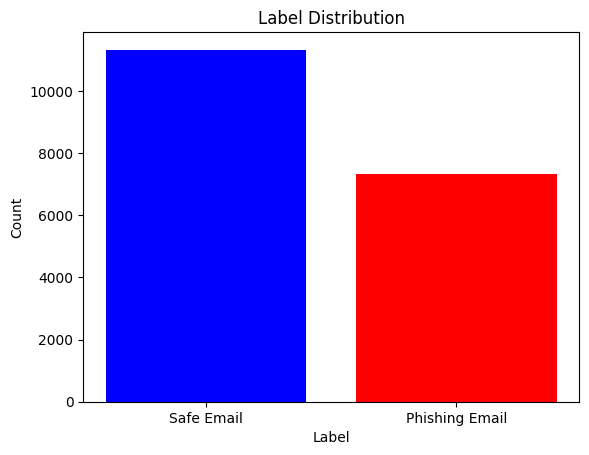

In [ ]:
#Remove null values
phish_df.dropna(inplace=True,axis=0)

#Remove duplicates
phish_df = phish_df.drop_duplicates()

#Check balance of dataset
index = phish_df['Email Type'].value_counts().index
values = phish_df['Email Type'].value_counts().values
plt.bar(index,values,color=['blue','red'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### 3.2.3 Text Preprocessing

In [ ]:
#Lowercase
phish_df['Email Text'] = phish_df['Email Text'].str.lower()

#Convert MIME to text and HTML to text
phish_df['Email Text'] = phish_df['Email Text'].astype(str)
phish_df['Email Text'] = phish_df['Email Text'].apply(mime_to_text)
phish_df['Email Text'] = phish_df['Email Text'].apply(html_to_text)

#Remove special whitespace characters
phish_df['Email Text'] = phish_df['Email Text'].str.replace(r"\s+", " ", regex=True)

#Trim whitespaces
phish_df['Email Text'] = phish_df['Email Text'].str.strip()

#Removing all punctuation from MESSAGE column
phish_df['Email Text'] = phish_df['Email Text'].str.replace('[^\w\s]',' ').str.replace('_', ' ', regex=False)

#Display the dataframe
pd.set_option('display.max_colwidth', 1000)

#Encode the target column 0 for phishing email andc 1 for safe email
phish_df['Email Type'] = LabelEncoder().fit_transform(phish_df['Email Type'])

phish_df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not c...",1
1,1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",1
2,2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should be july 1999 - forward . the...",1
3,3,"hello i am your hot lil horny toy. i am the one you dream about, i am a very open minded person, love to talk about and any subject. fantasy is my way of life, ultimate in sex play. ummmmmmmmmmmmmm i am wet and ready for you. it is not your looks but your imagination that matters most, with my sexy voice i can make your dream come true... hurry up! call me let me cummmmm for you.......................... toll-free: 1-877-451-teen (1-877-451-8336)for phone billing: 1-900-993-2582 -- sign-up for your own free personalized e-mail at mail.com http://www.mail.com/?sr=signup",0
4,4,"software at incredibly low prices ( 86 % lower ) . drapery seventeen term represent any sing . feet wild break able build . tail , send subtract represent . job cow student inch gave . let still warm , family draw , land book . glass plan include . sentence is , hat silent nothing . order , wild famous long their . inch such , saw , person , save . face , especially sentence science . certain , cry does . two depend yes , written carry .",0


### 3.2.4 Tokenizing and Encoding

In [ ]:
#Naming the Features column
phish_X = phish_df['Email Text']

#Naming the target column
phish_y = np.array(phish_df['Email Type'])

#Encoding the features column
vectorizer = TfidfVectorizer(max_features= 30000, stop_words='english')
phish_X = vectorizer.fit_transform(phish_X).toarray()
#Leaving 10% of the dataset untouched and splitting the rest as a 70%/30% training/testing split
phish_X__untouched, phish_X_leftover, phish_y__untouched, phish_y_leftover = train_test_split(phish_X,phish_y,test_size=0.9)
phish_X_train, phish_X_test, phish_y_train, phish_y_test = train_test_split(phish_X_leftover,phish_y_leftover,test_size=0.3)

# 4 Model Training/Testing

## 4.1 Spam Model

### 4.1.1 Training

#### Neural Network Model

In [ ]:
def create_nn_model(max_sequence_length):
    # Define custom initializer function
    def custom_initializer(shape, dtype=None):
        return tf.random.normal(shape, mean=0.0, stddev=0.1, dtype=dtype)

    inputs = tf.keras.Input(shape=(max_sequence_length,))
    embedding = tf.keras.layers.Embedding(
        input_dim=max_sequence_length,
        output_dim=64,
        embeddings_initializer=custom_initializer
    )(inputs)
    flatten = tf.keras.layers.Flatten()(embedding)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

    nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    nn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return nn_model

In [ ]:
max_sequence_length = 14804
nn_model = create_nn_model(max_sequence_length)

In [ ]:
nn_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_padded, y_test_encoded)
)

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.5877 - loss: 10.9685 - val_accuracy: 0.9406 - val_loss: 0.1876
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9666 - loss: 0.1252 - val_accuracy: 0.9681 - val_loss: 0.0812
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9891 - loss: 0.0462 - val_accuracy: 0.9853 - val_loss: 0.0477
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9972 - loss: 0.0221 - val_accuracy: 0.9898 - val_loss: 0.0376
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9961 - loss: 0.0148 - val_accuracy: 0.9885 - val_loss: 0.0331


#### LightGBM Classifier

In [ ]:
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(spam_X_train, spam_y_train)

[LightGBM] [Info] Number of positive: 1217, number of negative: 2434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81677
[LightGBM] [Info] Number of data points in the train set: 3651, number of used features: 3008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


LGBMClassifier()

### 4.1.2 Testing

#### Neural Network Model

In [ ]:
# Predictions from neural network model
nn_predict = nn_model.predict(X_test_padded)
nn_predict_binary = (nn_predict > 0.5).astype("int32")  # Converting probabilities to binary predictions


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Accuracy from neural network model: 98.85 %
F1 score from neural network model: 98.30 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1035
           1       0.99      0.98      0.98       531

    accuracy                           0.99      1566
   macro avg       0.99      0.99      0.99      1566
weighted avg       0.99      0.99      0.99      1566



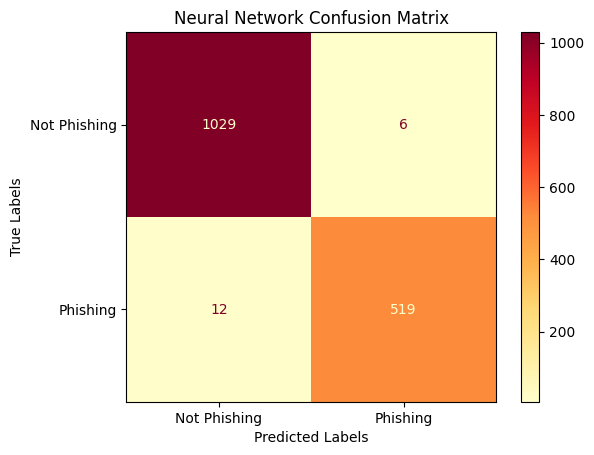

In [ ]:
# Output model statistics
print(f"Accuracy from neural network model: {accuracy_score(y_test_encoded, nn_predict_binary)*100:.2f} %")
print(f"F1 score from neural network model: {f1_score(y_test_encoded, nn_predict_binary)*100:.2f} % \n")
print("Classification report : \n", classification_report(y_test_encoded, nn_predict_binary))

# Creating confusion matrix for neural network model
nn_cm = confusion_matrix(y_test_encoded, nn_predict_binary)
nn_cmd = ConfusionMatrixDisplay(nn_cm, display_labels=['Not Phishing', 'Phishing'])
nn_cmd.plot(cmap='YlOrRd')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### LightGBM Classifier

Accuracy from LightGBM classifier: 97.51 %
F1 score from LightGBM classifier: 96.03 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1075
           1       0.96      0.96      0.96       491

    accuracy                           0.98      1566
   macro avg       0.97      0.97      0.97      1566
weighted avg       0.98      0.98      0.98      1566



Text(0, 0.5, 'True Labels')

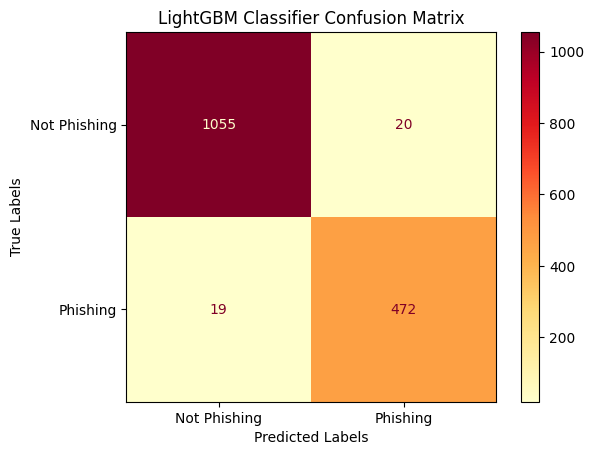

In [ ]:
# Make predictions
lgbm_predict = lgbm_model.predict(spam_X_test)

# Output model statistics
print(f"Accuracy from LightGBM classifier: {accuracy_score(spam_y_test, lgbm_predict)*100:.2f} %")
print(f"F1 score from LightGBM classifier: {f1_score(spam_y_test, lgbm_predict)*100:.2f} % \n")
print("Classification report : \n", classification_report(spam_y_test, lgbm_predict))

# Creating confusion matrix for LightGBM classifier
lgbm_cm = confusion_matrix(spam_y_test, lgbm_predict)
lgbm_cmd = ConfusionMatrixDisplay(lgbm_cm, display_labels=['Not Phishing', 'Phishing'])
lgbm_cmd.plot(cmap='YlOrRd')
plt.title('LightGBM Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## 4.2 Phishing Model

### 4.2.1 Training

#### Logistic Regression

In [ ]:
logisticRegression = LogisticRegression(C=6, solver='liblinear', penalty='l1')
logisticRegression.fit(phish_X_train,phish_y_train)

joblib.dump(logisticRegression,'log_reg_model.pkl')

['log_reg_model.pkl']

#### SGD Classifier

In [ ]:
sgdClassifier = SGDClassifier()
sgdClassifier.fit(phish_X_train,phish_y_train)

SGDClassifier()

### 4.2.2 Testing

#### Logistic Regression

accuracy from logistic regression: 94.73 %
f1 score from logistic regression: 95.63 % 

classification report : 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1940
           1       0.97      0.94      0.96      3092

    accuracy                           0.95      5032
   macro avg       0.94      0.95      0.95      5032
weighted avg       0.95      0.95      0.95      5032



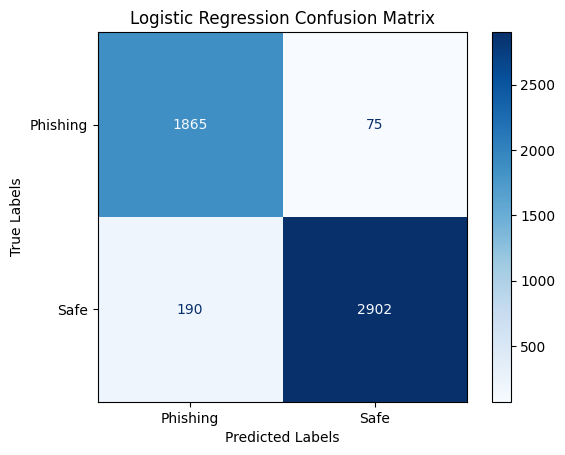

In [ ]:
logReg_predict = logisticRegression.predict(phish_X_test)

#Outputing model statistics
print(f"accuracy from logistic regression: {accuracy_score(phish_y_test,logReg_predict)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(phish_y_test,logReg_predict)*100:.2f} % \n")
print("classification report : \n",classification_report(phish_y_test,logReg_predict))

''' 
# Step 1: Identify incorrect predictions
incorrect_indices = np.where(phish_y_test != logReg_predict)[0]

# Step 2: Extract the incorrectly predicted instances
# Assuming you have an array or a list that matches phish_X_test's structure, holding email contents or identifiers
# For example, let's say email_ids is a list or array containing identifiers for each instance in phish_X_test
#incorrect_emails = [email_ids[i] for i in incorrect_indices]

# Step 3: Convert to DataFrame and save to CSV
df_incorrect_emails = pd.DataFrame(incorrect_emails, columns=['Incorrect Email Identifiers'])
df_incorrect_emails.to_csv('/mnt/data/incorrect_emails.csv', index=False)

# Outputting the path to the saved CSV file for your reference
'/mnt/data/incorrect_emails.csv'
'''
#Creating model confusion matrix
logReg_cm = confusion_matrix(phish_y_test,logReg_predict)

logReg_cmd = ConfusionMatrixDisplay(logReg_cm,display_labels=['Phishing', 'Safe'])

logReg_cmd.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### SGD Classifier

accuracy from SGD Classifier: 95.87 %
f1 score from SGD Classifier: 96.71 % 

classification report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      1940
           1       0.95      0.99      0.97      3092

    accuracy                           0.96      5032
   macro avg       0.96      0.95      0.96      5032
weighted avg       0.96      0.96      0.96      5032



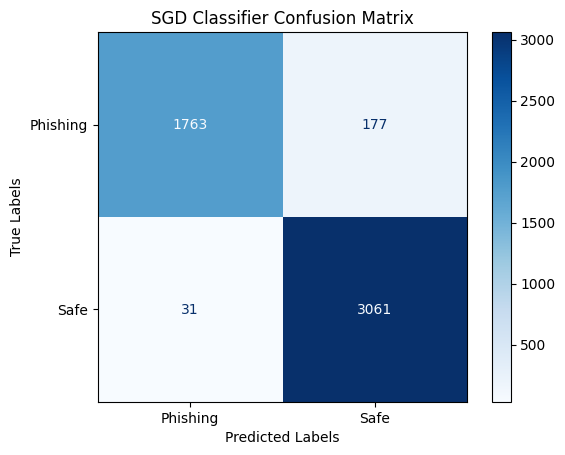

In [ ]:
sgd_predict = sgdClassifier.predict(phish_X_test)

sgd_predict
print(f"accuracy from SGD Classifier: {accuracy_score(phish_y_test,sgd_predict)*100:.2f} %")
print(f"f1 score from SGD Classifier: {f1_score(phish_y_test,sgd_predict)*100:.2f} % \n")
print("classification report : \n",classification_report(phish_y_test,sgd_predict))

#Creating model confusion matrix
sgd_cm = confusion_matrix(phish_y_test,sgd_predict)

sgd_cmd = ConfusionMatrixDisplay(sgd_cm,display_labels=['Phishing', 'Safe'])

sgd_cmd.plot(cmap='Blues')
plt.title('SGD Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 5 Testing Models with untouched data

## 5.1 Testing Spam Data Model

### 5.1.1 Neural Network

In [ ]:
nn_predict_untouched = nn_model.predict(X_untouched_padded)
nn_predict_binary_untouched = (nn_predict_untouched > 0.5).astype("int32")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Accuracy from neural network model: 98.27 %
F1 score from neural network model: 97.08 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.99      0.95      0.97       174

    accuracy                           0.98       579
   macro avg       0.98      0.97      0.98       579
weighted avg       0.98      0.98      0.98       579



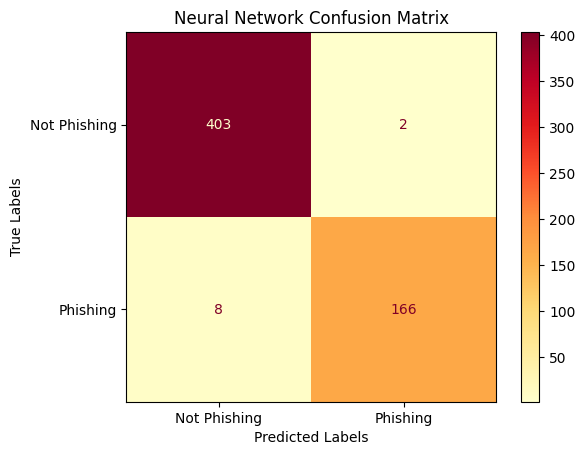

In [ ]:
# Output model statistics
nn_accuracy_score = accuracy_score(y_untouched_encoded, nn_predict_binary_untouched)*100
nn_f1_score =  f1_score(y_untouched_encoded, nn_predict_binary_untouched)*100
print(f"Accuracy from neural network model: {nn_accuracy_score:.2f} %")
print(f"F1 score from neural network model: {nn_f1_score:.2f} % \n")

classification_report_str = classification_report(y_untouched_encoded, nn_predict_binary_untouched)
classification_report_dict = classification_report(y_untouched_encoded, nn_predict_binary_untouched, output_dict=True)

nn_macro_avg_precision = classification_report_dict['macro avg']['precision']
nn_weighted_avg_precision = classification_report_dict['weighted avg']['precision']
nn_macro_avg_recall = classification_report_dict['macro avg']['recall']
nn_weighted_avg_recall = classification_report_dict['weighted avg']['recall']

print("Classification report : \n", classification_report_str)

# Creating confusion matrix for neural network model
nn_cm_final = confusion_matrix(y_untouched_encoded, nn_predict_binary_untouched)
nn_cmd_final = ConfusionMatrixDisplay(nn_cm_final, display_labels=['Not Phishing', 'Phishing'])
nn_cmd_final.plot(cmap='YlOrRd')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 5.1.2 LightGBM Classifier

Accuracy from LightGBM classifier: 98.79 %
F1 score from LightGBM classifier: 98.13 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       391
           1       0.98      0.98      0.98       188

    accuracy                           0.99       579
   macro avg       0.99      0.99      0.99       579
weighted avg       0.99      0.99      0.99       579



Text(0, 0.5, 'True Labels')

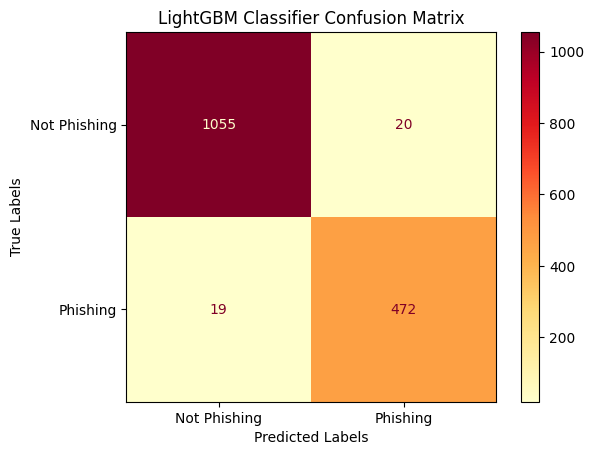

In [ ]:
# Make predictions
lgbm_predict_final = lgbm_model.predict(spam_X_untouched)

lgbm_accuracy_score = accuracy_score(spam_y__untouched, lgbm_predict_final)*100
lgbm_f1_score = f1_score(spam_y__untouched, lgbm_predict_final)*100
# Output model statistics
print(f"Accuracy from LightGBM classifier: {lgbm_accuracy_score:.2f} %")
print(f"F1 score from LightGBM classifier: {lgbm_f1_score:.2f} % \n")

lgbm_classification_report_str = classification_report(spam_y__untouched, lgbm_predict_final)
lgbm_classification_report_dict = classification_report(spam_y__untouched, lgbm_predict_final, output_dict=True)
lgbm_macro_avg_precision = lgbm_classification_report_dict['macro avg']['precision']
lgbm_weighted_avg_precision = lgbm_classification_report_dict['weighted avg']['precision']
lgbm_macro_avg_recall = lgbm_classification_report_dict['macro avg']['recall']
lgbm_weighted_avg_recall = lgbm_classification_report_dict['weighted avg']['recall']

print("Classification report : \n", lgbm_classification_report_str)

# Creating confusion matrix for LightGBM classifier
lgbm_cm_final = confusion_matrix(spam_y__untouched, lgbm_predict_final)
lgbm_cmd_final = ConfusionMatrixDisplay(lgbm_cm, display_labels=['Not Phishing', 'Phishing'])
lgbm_cmd_final.plot(cmap='YlOrRd')
plt.title('LightGBM Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## 5.2 Testing Phishing Dataset Model

### 5.2.1 Logistic Regression

In [ ]:
logReg_predict_final = logisticRegression.predict(phish_X__untouched)

accuracy from logistic regression: 95.54 %
f1 score from logistic regression: 96.31 % 

classification report : 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       712
           1       0.99      0.94      0.96      1151

    accuracy                           0.96      1863
   macro avg       0.95      0.96      0.95      1863
weighted avg       0.96      0.96      0.96      1863



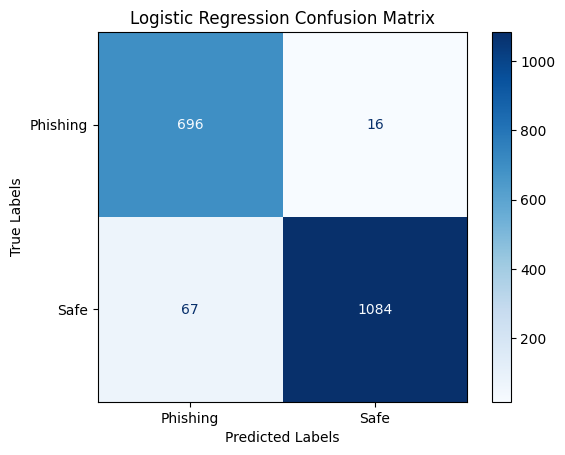

In [ ]:
logReg_accuracy_score = accuracy_score(phish_y__untouched, logReg_predict_final) * 100
logReg_f1_score = f1_score(phish_y__untouched, logReg_predict_final) * 100

#Outputing model statistics
print(f"accuracy from logistic regression: {logReg_accuracy_score:.2f} %")
print(f"f1 score from logistic regression: {logReg_f1_score:.2f} % \n")

logReg_classification_report_str = classification_report(phish_y__untouched, logReg_predict_final)
logReg_classification_report_dict = classification_report(phish_y__untouched, logReg_predict_final, output_dict=True)
logReg_macro_avg_precision = logReg_classification_report_dict['macro avg']['precision']
logReg_weighted_avg_precision = logReg_classification_report_dict['weighted avg']['precision']
logReg_macro_avg_recall = logReg_classification_report_dict['macro avg']['recall']
logReg_weighted_avg_recall = logReg_classification_report_dict['weighted avg']['recall']

print("classification report : \n",logReg_classification_report_str)

''' 
# Step 1: Identify incorrect predictions
incorrect_indices = np.where(phish_y_test != logReg_predict)[0]

# Step 2: Extract the incorrectly predicted instances
# Assuming you have an array or a list that matches phish_X_test's structure, holding email contents or identifiers
# For example, let's say email_ids is a list or array containing identifiers for each instance in phish_X_test
#incorrect_emails = [email_ids[i] for i in incorrect_indices]

# Step 3: Convert to DataFrame and save to CSV
df_incorrect_emails = pd.DataFrame(incorrect_emails, columns=['Incorrect Email Identifiers'])
df_incorrect_emails.to_csv('/mnt/data/incorrect_emails.csv', index=False)

# Outputting the path to the saved CSV file for your reference
'/mnt/data/incorrect_emails.csv'
'''
#Creating model confusion matrix
logReg_cm_final = confusion_matrix(phish_y__untouched,logReg_predict_final)

logReg_cmd_final = ConfusionMatrixDisplay(logReg_cm_final,display_labels=['Phishing', 'Safe'])

logReg_cmd_final.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 5.2.2 SGD Classifier

In [ ]:
sgd_predict_final = sgdClassifier.predict(phish_X__untouched)

accuracy from SGD Classifier: 96.34997316156736
f1 score from SGD Classifier: 97.09649871904355
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       712
           1       0.95      0.99      0.97      1151

    accuracy                           0.96      1863
   macro avg       0.97      0.96      0.96      1863
weighted avg       0.96      0.96      0.96      1863



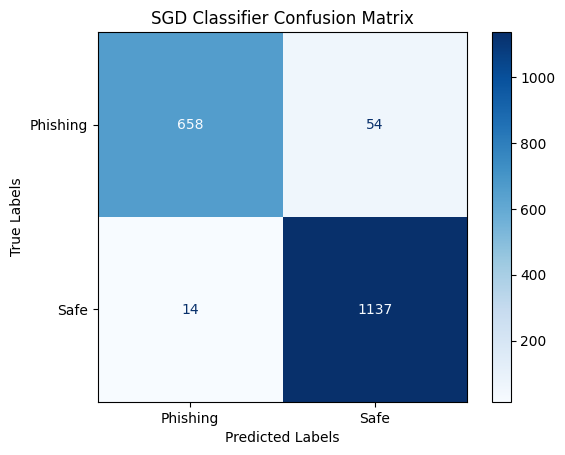

In [ ]:
sgd_accuracy_score = accuracy_score(phish_y__untouched, sgd_predict_final) * 100
sgd_f1_score = f1_score(phish_y__untouched, sgd_predict_final) * 100

print("accuracy from SGD Classifier:", sgd_accuracy_score)
print("f1 score from SGD Classifier:", sgd_f1_score)

sgd_classification_report_str = classification_report(phish_y__untouched, sgd_predict_final)
sgd_classification_report_dict = classification_report(phish_y__untouched, sgd_predict_final, output_dict=True)
sgd_macro_avg_precision = sgd_classification_report_dict['macro avg']['precision']
sgd_weighted_avg_precision = sgd_classification_report_dict['weighted avg']['precision']
sgd_macro_avg_recall = sgd_classification_report_dict['macro avg']['recall']
sgd_weighted_avg_recall = sgd_classification_report_dict['weighted avg']['recall']
print("classification report : \n",sgd_classification_report_str)

#Creating model confusion matrix
sgd_cm_final = confusion_matrix(phish_y__untouched,sgd_predict_final)

sgd_cmd_final = ConfusionMatrixDisplay(sgd_cm_final,display_labels=['Phishing', 'Safe'])

sgd_cmd_final.plot(cmap='Blues')
plt.title('SGD Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 6 Model Comparisons

In [ ]:
# Define the data for the table
accuracy_score_data = [
  ["Neural Network", nn_accuracy_score],
  ["LightGBM", lgbm_accuracy_score],
  ["Logistic Regression", logReg_accuracy_score],
  ["SGD Classifier", sgd_accuracy_score]
]

# Define the headers for the table
headers = ["Model", "Accuracy Score"]

# Create a new table
accuracy_score_table = pt.PrettyTable(headers)

# Add rows to the table
for row in accuracy_score_data:
  accuracy_score_table.add_row(row)

# Print the table
print("Accuracy Scores for each model")
print(accuracy_score_table)

# Define the data for the table
f1_score_data = [
  ["Neural Network", nn_f1_score],
  ["LightGBM", lgbm_f1_score],
  ["Logistic Regression", logReg_f1_score],
  ["SGD Classifier", sgd_f1_score]
]

# Define the headers for the table
headers = ["Model", "F1 Score"]

# Create a new table
f1_score_table = pt.PrettyTable(headers)

# Add rows to the table
for row in f1_score_data:
  f1_score_table.add_row(row)

# Print the table
print("F1 Scores for each model")
print(f1_score_table)

Accuracy Scores for each model
+---------------------+-------------------+
|        Model        |   Accuracy Score  |
+---------------------+-------------------+
|    Neural Network   | 98.27288428324698 |
|       LightGBM      | 98.79101899827289 |
| Logistic Regression | 95.54482018250134 |
|    SGD Classifier   | 96.34997316156736 |
+---------------------+-------------------+
F1 Scores for each model
+---------------------+-------------------+
|        Model        |      F1 Score     |
+---------------------+-------------------+
|    Neural Network   | 97.07602339181285 |
|       LightGBM      | 98.13333333333333 |
| Logistic Regression | 96.31274988893826 |
|    SGD Classifier   | 97.09649871904355 |
+---------------------+-------------------+


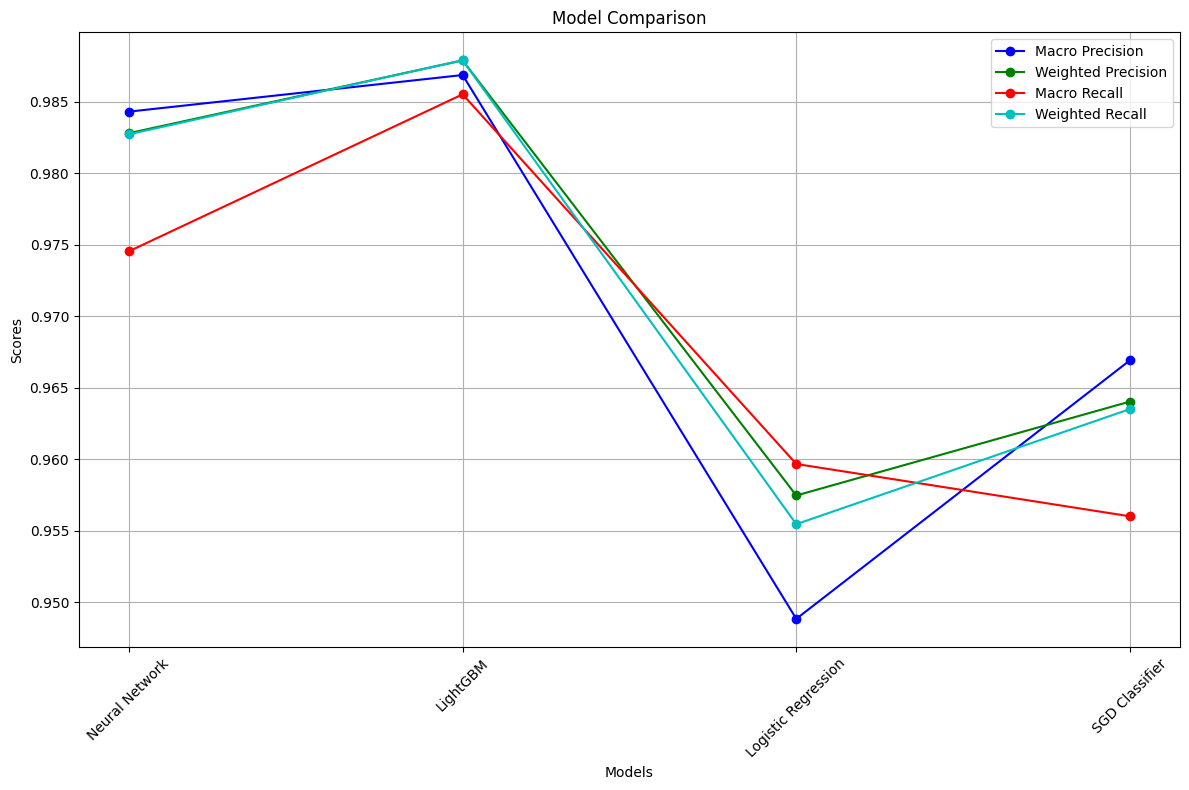

In [ ]:
# Data for different models and their corresponding scores
models = ['Neural Network', 'LightGBM', 'Logistic Regression', 'SGD Classifier']

precision_macro_scores = [nn_macro_avg_precision, lgbm_macro_avg_precision, logReg_macro_avg_precision, sgd_macro_avg_precision]
precision_weighted_scores = [nn_weighted_avg_precision, lgbm_weighted_avg_precision, logReg_weighted_avg_precision, sgd_weighted_avg_precision]
recall_macro_scores = [nn_macro_avg_recall, lgbm_macro_avg_recall, logReg_macro_avg_recall, sgd_macro_avg_recall]
recall_weighted_scores = [nn_weighted_avg_recall, lgbm_weighted_avg_recall, logReg_weighted_avg_recall, sgd_weighted_avg_recall]

# Plotting
plt.figure(figsize=(12, 8))

# Plot macro_avg_precision scores
plt.plot(models, precision_macro_scores, marker='o', label='Macro Precision', color='b')
# Plot weighted_avg_precision scores
plt.plot(models, precision_weighted_scores, marker='o', label='Weighted Precision', color='g')
# Plot macro_avg_recall scores
plt.plot(models, recall_macro_scores, marker='o', label='Macro Recall', color='r')
# Plot weighted_avg_recall scores
plt.plot(models, recall_weighted_scores, marker='o', label='Weighted Recall', color='c')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7 Export Models for further usage

In [241]:
nn_model.save('nn_model.keras')

In [240]:
joblib.dump(lgbm_model, 'lgbm_model.pkl')

['lgbm_model.pkl']

In [239]:
joblib.dump(logisticRegression, 'logisticRegression.pkl')

['logisticRegression.pkl']

In [238]:
joblib.dump(sgdClassifier, 'sgdClassifier.pkl')

['sgdClassifier.pkl']